<a href="https://colab.research.google.com/github/MichalBalcerak/ML24-25/blob/main/Homework09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First, I loaded the MNIST dataset and trained a model as we did during the class.

In [27]:
import torch
import torchvision
from matplotlib import pyplot as plt

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=None)

In [28]:
(trainset.data.numpy().mean()/255.0, trainset.data.numpy().std()/255.0)

(np.float64(0.1306604762738429), np.float64(0.30810780385646264))

In [29]:
transform = torchvision.transforms.Compose(
    [ torchvision.transforms.ToTensor(),
      torchvision.transforms.Normalize((0.1307), (0.3081))])

trainset = torchvision.datasets.MNIST(root='./data',
                                      train=True,
                                      download=True,
                                      transform=transform)

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=2048,
                                          shuffle=True)

testset = torchvision.datasets.MNIST(root='./data',
                                     train=False,
                                     download=True,
                                     transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=1,
                                         shuffle=False)

In [30]:
class MLP(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.relu = torch.nn.ReLU()
        self.flatten = torch.nn.Flatten()
        self.linear1 = torch.nn.Linear(1*28*28, 1024)

        self.linear2 = torch.nn.Linear(1024, 2048)
        self.linear3 = torch.nn.Linear(2048, 256)
        self.linear4 = torch.nn.Linear(256, 10)


        self.dropout = torch.nn.Dropout(0.05)

    def forward(self, x):      # B, 1, 28, 28
        x = self.flatten(x)    # B, 784

        x = self.linear1(x)
        x = self.relu(x)

        x = self.linear2(x)
        x = self.relu(x)

        x = self.linear3(x)
        x = self.relu(x)

        x = self.linear4(x)

        x = self.dropout(x)
        return x

In [31]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

net = MLP().to(device)
optimizer = torch.optim.Adam(net.parameters(), 0.001)

net.train()
for epoch in range(8):

    for batch, data in enumerate(trainloader):
        batch_inputs, batch_labels = data

        batch_inputs = batch_inputs.to(device)
        batch_labels = batch_labels.to(device)

        #batch_inputs.squeeze(1)

        optimizer.zero_grad()

        batch_outputs = net(batch_inputs)

        loss = torch.nn.functional.cross_entropy(batch_outputs, batch_labels, reduction = "mean")
        print("epoch:", epoch, "batch:", batch, "current batch loss:", loss.item())
        loss.backward()
        optimizer.step()


Working on cpu
epoch: 0 batch: 0 current batch loss: 2.3052313327789307
epoch: 0 batch: 1 current batch loss: 2.1015520095825195
epoch: 0 batch: 2 current batch loss: 1.6547836065292358
epoch: 0 batch: 3 current batch loss: 1.137293815612793
epoch: 0 batch: 4 current batch loss: 0.9141491651535034
epoch: 0 batch: 5 current batch loss: 1.2168065309524536
epoch: 0 batch: 6 current batch loss: 0.9740987420082092
epoch: 0 batch: 7 current batch loss: 0.8185481429100037
epoch: 0 batch: 8 current batch loss: 0.8159881234169006
epoch: 0 batch: 9 current batch loss: 0.6747990846633911
epoch: 0 batch: 10 current batch loss: 0.5634691715240479
epoch: 0 batch: 11 current batch loss: 0.5527202486991882
epoch: 0 batch: 12 current batch loss: 0.5492799878120422
epoch: 0 batch: 13 current batch loss: 0.506744921207428
epoch: 0 batch: 14 current batch loss: 0.505540668964386
epoch: 0 batch: 15 current batch loss: 0.42899322509765625
epoch: 0 batch: 16 current batch loss: 0.41917574405670166
epoch: 0 b

In [32]:
good = 0
wrong = 0

net.eval()
with torch.no_grad():
    for batch, data in enumerate(testloader):
        datapoint, label = data

        datapoint = datapoint.to(device)
        label = label.to(device)

        prediction = net(datapoint)
        classification = torch.argmax(prediction)


        if classification.item() == label.item():
            good += 1
        else:
            wrong += 1

print("accuracy = ", good/(good+wrong))

accuracy =  0.9825


Then I generated ten random Gaussian noise images with corresponding labels

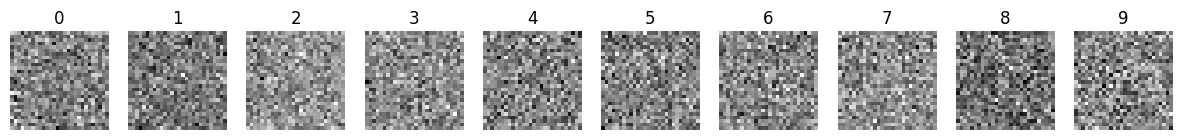

In [153]:
torch.manual_seed(42)

input_images = []
labels = []

for i in range(10):
   image = torch.randn((1, 1, 28, 28), requires_grad=True, device=device)
   input_images.append(image)
   labels.append(i)

fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    image_tensor = input_images[i].detach().cpu().squeeze()
    axs[i].imshow(image_tensor, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))

plt.show()

I optimized these images so that the model would classify them according to their assigned labels.

In [154]:
optimizer_list = [torch.optim.Adam([img], lr=0.001) for img in input_images]


confidence_history = [[] for _ in range(10)]
image_snapshots = [[] for _ in range(10)]

net.eval()

for step in range(800):
    for i in range(10):
        optimizer = optimizer_list[i]
        image = input_images[i]
        target_label = torch.tensor([labels[i]], device=device)

        optimizer.zero_grad()

        output = net(image)
        loss = torch.nn.functional.cross_entropy(output, target_label)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            image.clamp_(0, 1)

        if step % 10 == 0:
            probs = torch.softmax(output, dim=1)
            confidence = probs[0, labels[i]].item()
            confidence_history[i].append(confidence)
        if step % 50 == 0:
            snapshot = image.detach().cpu().clone().squeeze()
            image_snapshots[i].append(snapshot)

Images of the generated inputs at different steps - implementation for $5$ digit

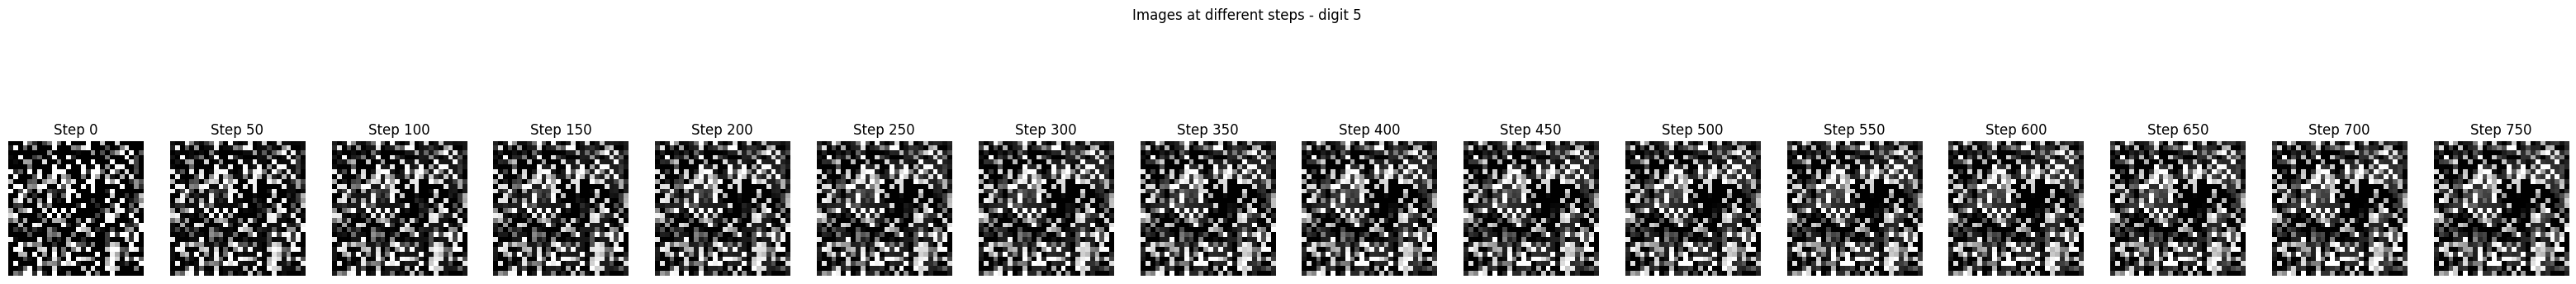

In [155]:
i=5
fig, axs = plt.subplots(1, len(image_snapshots[i]), figsize=(len(image_snapshots[i]) * 2.5, 5))
for j, snapshot in enumerate(image_snapshots[i]):
    axs[j].imshow(snapshot, cmap='gray')
    axs[j].axis('off')
    axs[j].set_title(f"Step {j*50}")
plt.suptitle(f"Images at different steps - digit {i}")
plt.show()

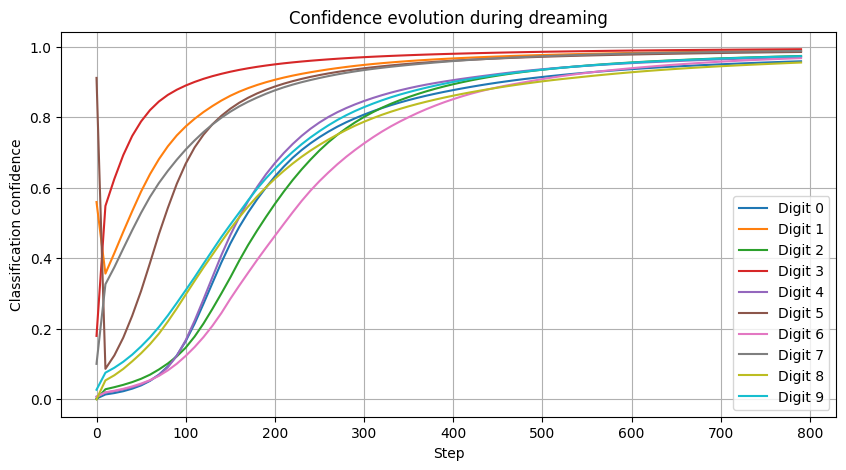

In [156]:
steps = [i * 10 for i in range(len(confidence_history[0]))]
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.plot(steps, confidence_history[i], label=f"Digit {i}")
plt.xlabel("Step")
plt.ylabel("Classification confidence")
plt.title("Confidence evolution during dreaming")
plt.legend()
plt.grid(True)
plt.show()

Interestingly, in some cases (look at digit 5) the model's confidence in the target digit temporarily decreases at the beginning of optimization.
This likely occurs because the model may recognise a target digit in the initial noise. The gradient descent updates do not preserve initial structure, and may momentarily disrupt features that the model associated with the digit.
Over time, however, the optimization reconstructs stronger features aligned with the target class, and the confidence rises again.

Generated images:

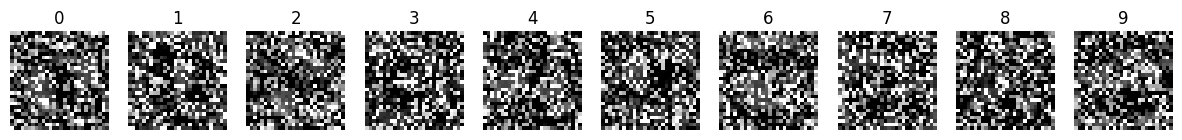

In [158]:
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    image_tensor = input_images[i].detach().cpu().squeeze()
    axs[i].imshow(image_tensor, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))

## Do the generated images resemble real MNIST digits? Why or why not?

No, the generated images do not resemble real MNIST digits.
The model classifies them correctly by relying on internal learned features that may not correspond to visual patterns humans expect.
The optimization process modifies the image to increase the model's confidence for a given class, but it does not enforce human-recognizable structure.
As a result, the model tends to amplify specific features it has learned to associate with each digit — even if those features are abstract, exaggerated, or imperceptible to humans.

##  Generating an image that bares similarity to two or more digits simultaneously

I decided to achieve this effect by using a loss function defined as the sum of cross-entropy losses for each digit the image is intended to resemble.

Below is the implementation of generating a hybrid between digits $4$ and $9$.

*Note that this approach allows us to generate a hybrid of more than two digits*

In [161]:
image = torch.randn((1, 1, 28, 28), requires_grad=True, device=device)
optimizer = torch.optim.Adam([image], lr=0.001)

digit_a = 4
digit_b = 9

target_label = [torch.tensor([digit_a], device=device), torch.tensor([digit_b], device=device)]

confidence_a_values = []
confidence_b_values = []
image_snapshots_ = []

net.eval()

for step in range(800):
      optimizer.zero_grad()


      output = net(image)

      loss = torch.nn.functional.cross_entropy(output, target_label[0]) + torch.nn.functional.cross_entropy(output, target_label[1])

      loss.backward()
      optimizer.step()

      with torch.no_grad():
          image.clamp_(0, 1)

      if step % 10 == 0:
          probs = torch.softmax(output, dim=1)
          confidence_a = probs[0, digit_a].item()
          confidence_b = probs[0, digit_b].item()

          confidence_a_values.append(confidence_a)
          confidence_b_values.append(confidence_b)

      if step % 50 == 0:
          snapshot = image.detach().cpu().clone().squeeze()
          image_snapshots_.append(snapshot)

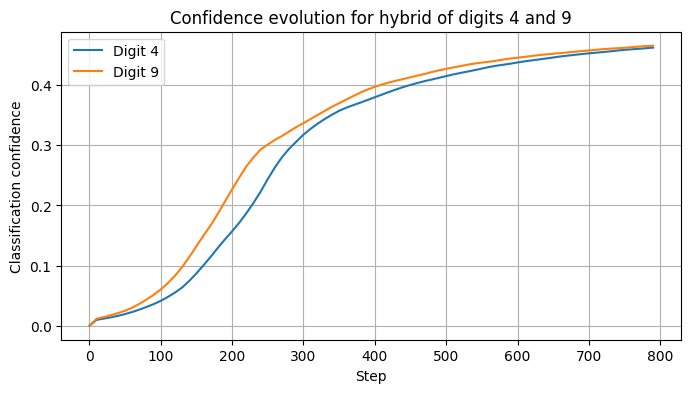

In [162]:
steps = [i * 10 for i in range(len(confidence_a_values))]

plt.figure(figsize=(8, 4))
plt.plot(steps, confidence_a_values, label=f"Digit {digit_a}")
plt.plot(steps, confidence_b_values, label=f"Digit {digit_b}")
plt.xlabel("Step")
plt.ylabel("Classification confidence")
plt.title(f"Confidence evolution for hybrid of digits {digit_a} and {digit_b}")
plt.legend()
plt.grid(True)
plt.show()

As we can see, the model predicts either $4$ or $9$ for the generated image, both probabilities are close to $0.5$ at the end of the optimization.

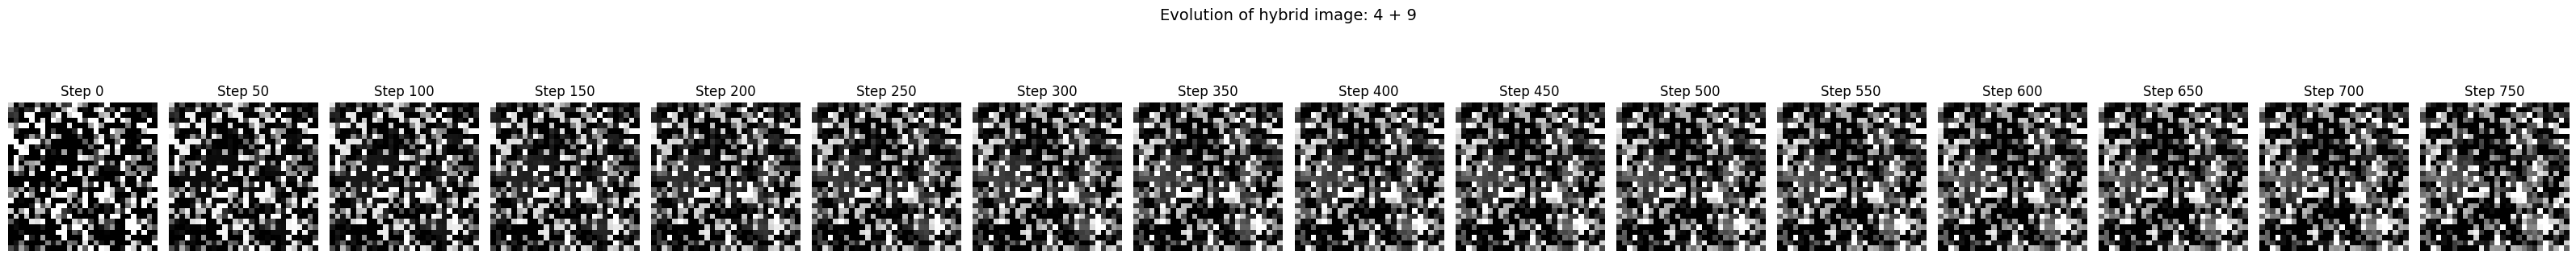

In [163]:
fig, axs = plt.subplots(1, len(image_snapshots_), figsize=(len(image_snapshots_) * 2, 4))
for j, snapshot in enumerate(image_snapshots_):
    axs[j].imshow(snapshot, cmap='gray')
    axs[j].axis('off')
    axs[j].set_title(f"Step {j * 50}")
plt.suptitle(f"Evolution of hybrid image: {digit_a} + {digit_b}", fontsize=14)
plt.tight_layout()
plt.show()

## Repeating the previous tasks with an additional L2 penalty on noise within the images

In [268]:
lambda_l2 = 10

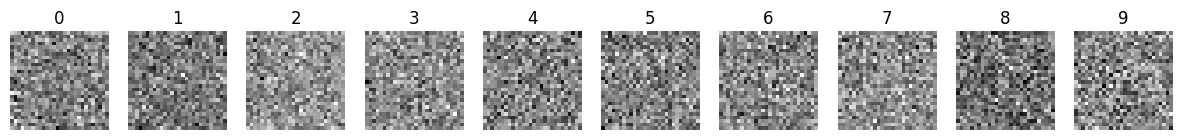

In [269]:
#Generating new noisy images

torch.manual_seed(42)

input_images = []
labels = []

for i in range(10):
   image = torch.randn((1, 1, 28, 28), requires_grad=True, device=device)
   input_images.append(image)
   labels.append(i)

fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    image_tensor = input_images[i].detach().cpu().squeeze()
    axs[i].imshow(image_tensor, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))

plt.show()

## Task 1 with L2 penalty

In [270]:
optimizer_list = [torch.optim.Adam([img], lr=0.01) for img in input_images]


confidence_history = [[] for _ in range(10)]
image_snapshots = [[] for _ in range(10)]

net.eval()

for step in range(800):
    for i in range(10):
        optimizer = optimizer_list[i]
        image = input_images[i]
        target_label = torch.tensor([labels[i]], device=device)

        optimizer.zero_grad()

        output = net(image)

        l2_penalty = image.pow(2).mean()

        loss = torch.nn.functional.cross_entropy(output, target_label) + lambda_l2 * l2_penalty
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            image.clamp_(0, 1)

        if step % 10 == 0:
            probs = torch.softmax(output, dim=1)
            confidence = probs[0, labels[i]].item()
            confidence_history[i].append(confidence)
        if step % 50 == 0:
            snapshot = image.detach().cpu().clone().squeeze()
            image_snapshots[i].append(snapshot)




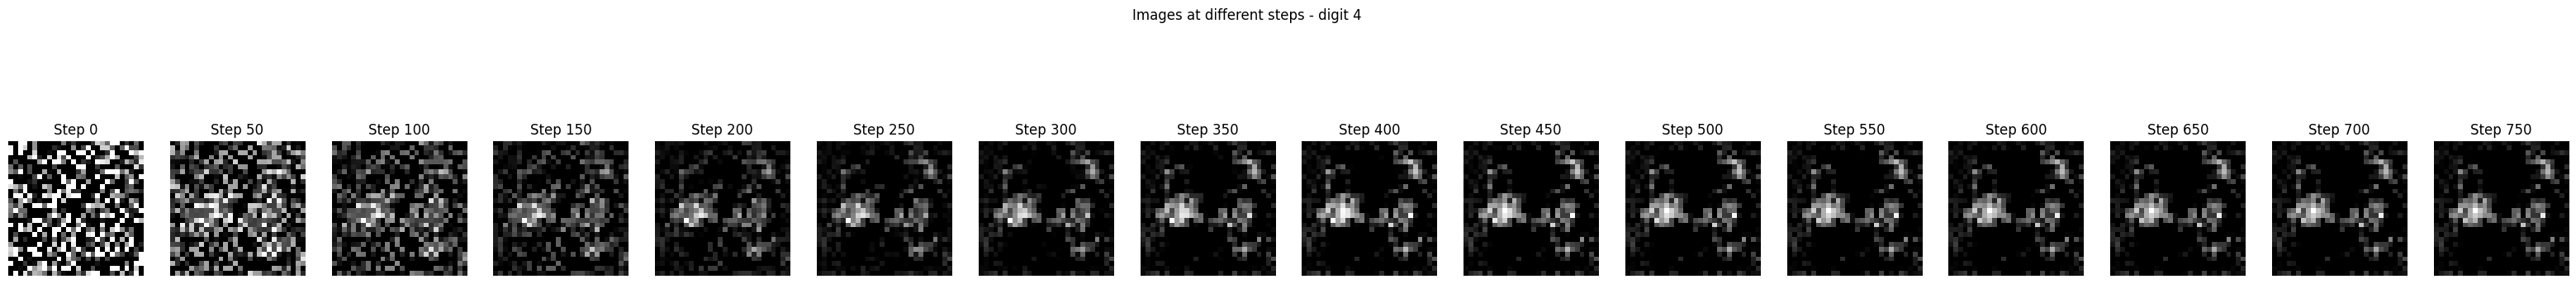

In [271]:
i=4
fig, axs = plt.subplots(1, len(image_snapshots[i]), figsize=(len(image_snapshots[i]) * 2.5, 5))
for j, snapshot in enumerate(image_snapshots[i]):
    axs[j].imshow(snapshot, cmap='gray')
    axs[j].axis('off')
    axs[j].set_title(f"Step {j*50}")
plt.suptitle(f"Images at different steps - digit {i}")
plt.show()

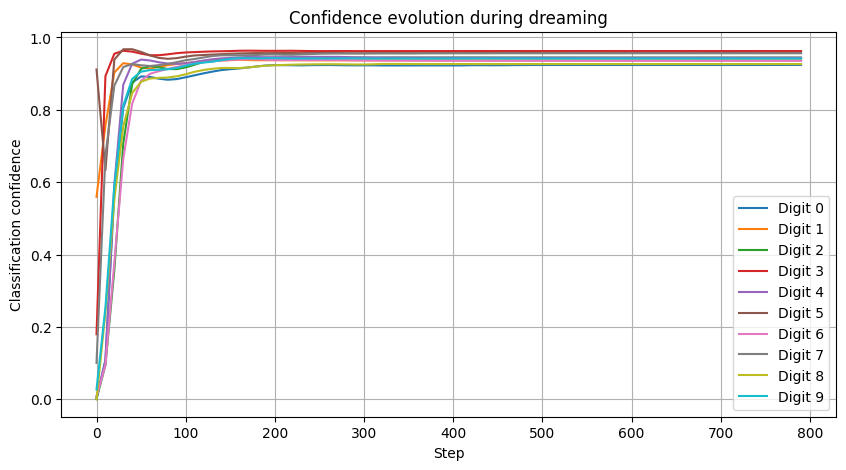

In [272]:
steps = [i * 10 for i in range(len(confidence_history[0]))]
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.plot(steps, confidence_history[i], label=f"Digit {i}")
plt.xlabel("Step")
plt.ylabel("Classification confidence")
plt.title("Confidence evolution during dreaming")
plt.legend()
plt.grid(True)
plt.show()

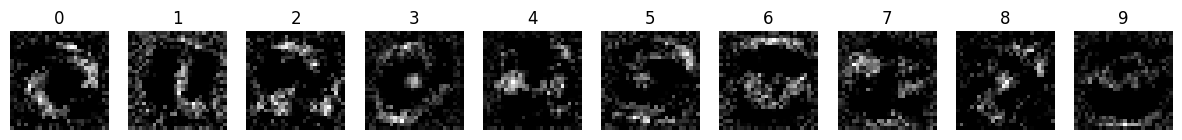

In [273]:
fig, axs = plt.subplots(1, 10, figsize=(15, 2))
for i in range(10):
    image_tensor = input_images[i].detach().cpu().squeeze()
    axs[i].imshow(image_tensor, cmap='gray')
    axs[i].axis('off')
    axs[i].set_title(str(i))

## Task 2 with L2 penalty

In [275]:
image = torch.randn((1, 1, 28, 28), requires_grad=True, device=device)
optimizer = torch.optim.Adam([image], lr=0.01)

digit_a = 4
digit_b = 9

target_label = [torch.tensor([digit_a], device=device), torch.tensor([digit_b], device=device)]

confidence_a_values = []
confidence_b_values = []
image_snapshots_ = []

net.eval()

for step in range(800):
      optimizer.zero_grad()


      output = net(image)

      l2_penalty = image.pow(2).mean()

      loss = torch.nn.functional.cross_entropy(output, target_label[0]) + torch.nn.functional.cross_entropy(output, target_label[1])+ lambda_l2 * l2_penalty

      loss.backward()
      optimizer.step()

      with torch.no_grad():
          image.clamp_(0, 1)

      if step % 10 == 0:
          probs = torch.softmax(output, dim=1)
          confidence_a = probs[0, digit_a].item()
          confidence_b = probs[0, digit_b].item()

          confidence_a_values.append(confidence_a)
          confidence_b_values.append(confidence_b)

      if step % 50 == 0:
          snapshot = image.detach().cpu().clone().squeeze()
          image_snapshots_.append(snapshot)

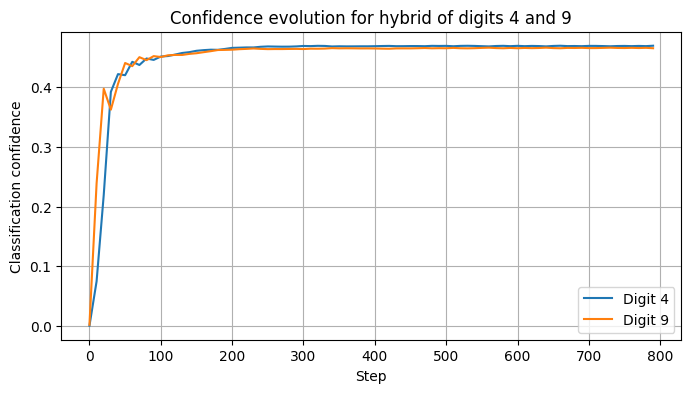

In [276]:
steps = [i * 10 for i in range(len(confidence_a_values))]

plt.figure(figsize=(8, 4))
plt.plot(steps, confidence_a_values, label=f"Digit {digit_a}")
plt.plot(steps, confidence_b_values, label=f"Digit {digit_b}")
plt.xlabel("Step")
plt.ylabel("Classification confidence")
plt.title(f"Confidence evolution for hybrid of digits {digit_a} and {digit_b}")
plt.legend()
plt.grid(True)
plt.show()

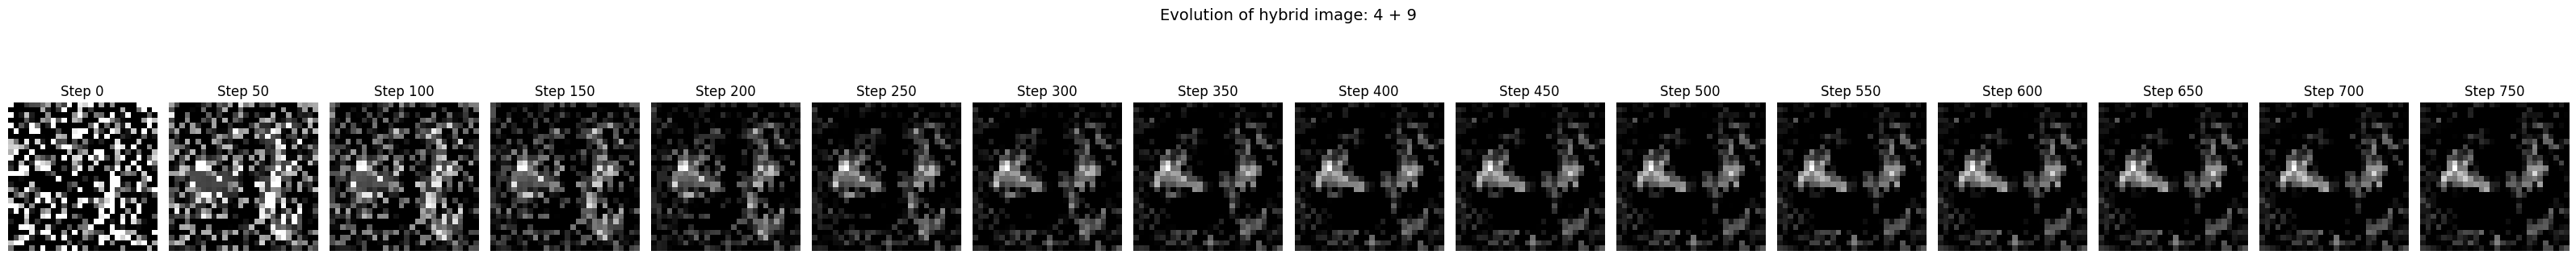

In [277]:
fig, axs = plt.subplots(1, len(image_snapshots_), figsize=(len(image_snapshots_) * 2, 4))
for j, snapshot in enumerate(image_snapshots_):
    axs[j].imshow(snapshot, cmap='gray')
    axs[j].axis('off')
    axs[j].set_title(f"Step {j * 50}")
plt.suptitle(f"Evolution of hybrid image: {digit_a} + {digit_b}", fontsize=14)
plt.tight_layout()
plt.show()

Higher values of `lambda_l2` cause the generated images to resemble actual digits more closely during the optimization process.
This happens because the modified loss function penalizes images with "extreme" pixel values — meaning highly activated, high-contrast patterns that the model might exploit to maximize confidence.
Without the L2 penalty, the optimization may exaggerate specific internal features learned by the model, leading to noisy or unnatural images.
By adding the penalty term, the optimization is discouraged from producing such high-intensity patterns, resulting in smoother, more natural images that are easier for humans to recognize as digits.